In [ ]:
! pip install gaminet

In [ ]:
%matplotlib inline

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

In [ ]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def load_ch():

    from sklearn.datasets import fetch_california_housing
    cal_housing = fetch_california_housing()
    x, y = cal_housing.data, cal_housing.target.reshape(-1, 1)

    task_type = "Regression"
    meta_info = {cal_housing.feature_names[i]:{'type':'continuous'} for i in range(x.shape[1])}
    meta_info.update({'Y':{'type':'target'}})
    return x, y, task_type, meta_info

def load_regression_data(name):
    func_dict = {'ch':load_ch}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_()
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                sy = MinMaxScaler((0, 1))
                y = sy.fit_transform(y)
                meta_info[key]['scaler'] = sy
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)
    return wrapper

In [ ]:
random_state = 0
data_loader = load_regression_data("ch")
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(random_state)

In [ ]:
model = GAMINet(meta_info=meta_info, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5,
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu,
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500,
            lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[5, 5, 5],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            verbose=True, val_ratio=0.2, random_state=2024)
model.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.12998, val loss: 0.12570
Main effects training epoch: 2, train loss: 0.05972, val loss: 0.05601
Main effects training epoch: 3, train loss: 0.05359, val loss: 0.05027
Main effects training epoch: 4, train loss: 0.04816, val loss: 0.04536
Main effects training epoch: 5, train loss: 0.03851, val loss: 0.03666
Main effects training epoch: 6, train loss: 0.02962, val loss: 0.02873
Main effects training epoch: 7, train loss: 0.02762, val loss: 0.02697
Main effects training epoch: 8, train loss: 0.02696, val loss: 0.02628
Main effects training epoch: 9, train loss: 0.02659, val loss: 0.02586
Main effects training epoch: 10, train loss: 0.02597, val loss: 0.02522
Main effects training epoch: 11, train loss: 0.02562, val loss: 0.02486
Main effects training epoch: 12, train loss: 0.02526, val loss: 0.02446
Main effects training e

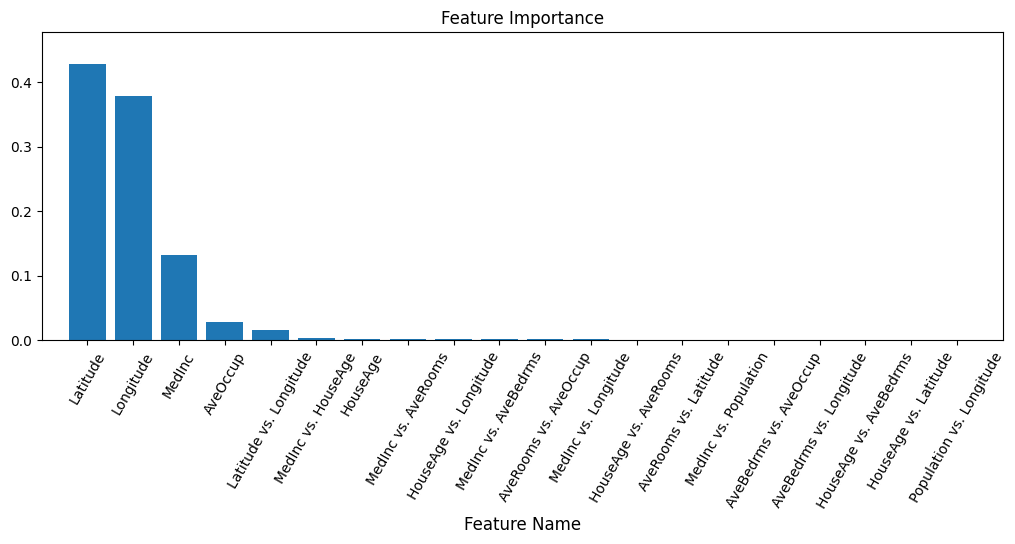

In [ ]:
data_dict_global = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict_global)

In [23]:
model = GAMINet(meta_info=meta_info, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5,
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu,
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500,
            lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[5, 5, 5],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            verbose=True, val_ratio=0.2, random_state=1)
model.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.10977, val loss: 0.10687
Main effects training epoch: 2, train loss: 0.05306, val loss: 0.05130
Main effects training epoch: 3, train loss: 0.04557, val loss: 0.04399
Main effects training epoch: 4, train loss: 0.03582, val loss: 0.03434
Main effects training epoch: 5, train loss: 0.02902, val loss: 0.02758
Main effects training epoch: 6, train loss: 0.02744, val loss: 0.02608
Main effects training epoch: 7, train loss: 0.02668, val loss: 0.02539
Main effects training epoch: 8, train loss: 0.02606, val loss: 0.02484
Main effects training epoch: 9, train loss: 0.02560, val loss: 0.02447
Main effects training epoch: 10, train loss: 0.02518, val loss: 0.02409
Main effects training epoch: 11, train loss: 0.02478, val loss: 0.02372
Main effects training epoch: 12, train loss: 0.02438, val loss: 0.02335
Main effects training e

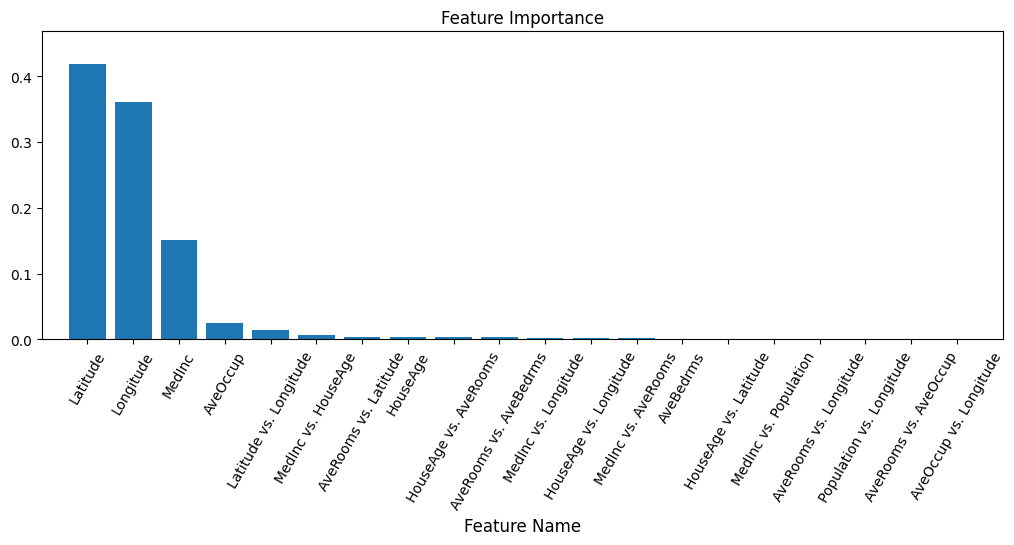

In [24]:
data_dict_global = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict_global)